<a href="https://colab.research.google.com/github/maria-igntv/speech_technology_mipt_vk/blob/main/HW1_Mel_spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ1
Реализовать mel-спектрограмму с использованием numpy и библиотеки чтения аудиофайла(например, soundfile)
Визуализировать можно с помощью matplotlib

In [62]:
%%capture

!pip uninstall -y torchaudio torch librosa
!pip install torch torchaudio librosa
!pip install audiomentations

In [63]:
import torchaudio

In [64]:
import librosa
import librosa.display
import IPython.display as ip
from IPython.display import Audio
path_to_save = '/content'
import numpy as np
import matplotlib.pyplot as plt

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

Audio data shape: (117601,)
Sample rate: 22050


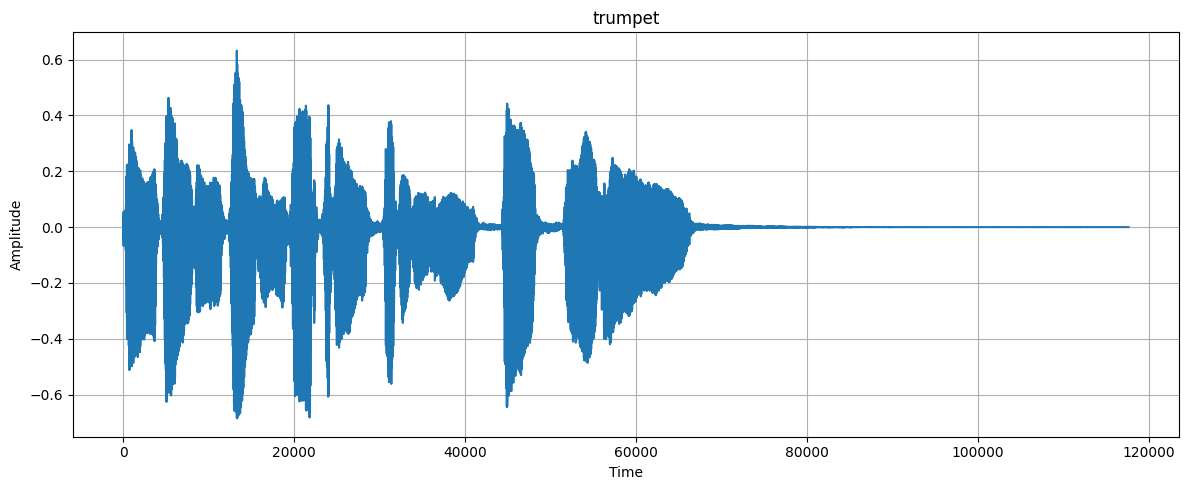

In [65]:
audio_path = librosa.ex('trumpet')
wav, sr = librosa.load(audio_path)

print(f"Audio data shape: {wav.shape}")
print(f"Sample rate: {sr}")
display(Audio(data=wav, rate=sr))

# Plot with time axis
plt.figure(figsize=(12, 5))
plt.plot(wav)
plt.title('trumpet')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
wav, sr

(array([-1.4068222e-03, -4.4607258e-04, -4.1098078e-04, ...,
         7.9623051e-06, -3.0417003e-05,  1.2765067e-05], dtype=float32),
 22050)

In [68]:
n_fft = 2048
hop_length = 512
n_mels = 128
fmin = 0
fmax = sr // 2

In [69]:
def frame_signal(signal, frame_length, hop_length):
    n_frames = 1 + (len(signal) - frame_length) // hop_length
    frames = np.lib.stride_tricks.sliding_window_view(signal, window_shape=frame_length)[::hop_length]
    return frames[:n_frames]

In [70]:
if len(wav) < n_fft:
    wav = np.pad(wav, (0, n_fft - len(wav)), mode='constant')
else:
    extra = (len(wav) - n_fft) % hop_length
    if extra != 0:
        wav = np.pad(wav, (0, hop_length - extra), mode='constant')

frames = frame_signal(wav, n_fft, hop_length)
print("Форма фреймов:", frames.shape)

Форма фреймов: (227, 2048)


In [71]:
window = np.hanning(n_fft)

windowed_frames = frames * window

stft_matrix = np.fft.rfft(windowed_frames, n=n_fft)  # rfft — для вещественного сигнала

print("Форма STFT:", stft_matrix.shape)

Форма STFT: (227, 1025)


In [72]:
magnitude_spectrogram = np.abs(stft_matrix)
power_spectrogram = magnitude_spectrogram ** 2

print("Форма power spectrogram:", power_spectrogram.shape)

Форма power spectrogram: (227, 1025)


In [73]:
power_spectrogram = np.abs(stft_matrix) ** 2  # (n_frames, n_freq_bins)

In [74]:
n_freqs = stft_matrix.shape[1]  # = n_fft // 2 + 1
linear_freqs = np.linspace(0, sr / 2, n_freqs)  # Гц

def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10 ** (mel / 2595) - 1)

In [75]:
mel_min = hz_to_mel(fmin)
mel_max = hz_to_mel(fmax)
mel_points = np.linspace(mel_min, mel_max, n_mels + 2)  # +2 для граничных фильтров
hz_points = mel_to_hz(mel_points)

bin_width = sr / n_fft
fft_bins = np.floor(hz_points / bin_width).astype(int)
fft_bins = np.clip(fft_bins, 0, n_freqs - 1)


In [76]:
mel_filterbank = np.zeros((n_mels, n_freqs))
for m in range(n_mels):
    left = fft_bins[m]
    center = fft_bins[m + 1]
    right = fft_bins[m + 2]

    if center > left:
        mel_filterbank[m, left:center] = (np.arange(left, center) - left) / (center - left)
    if right > center:
        mel_filterbank[m, center:right] = (right - np.arange(center, right)) / (right - center)

In [77]:
mel_spectrogram = np.dot(mel_filterbank, power_spectrogram.T).T  # (n_frames, n_mels)

In [78]:
log_mel_spectrogram = np.log(mel_spectrogram + 1e-10)

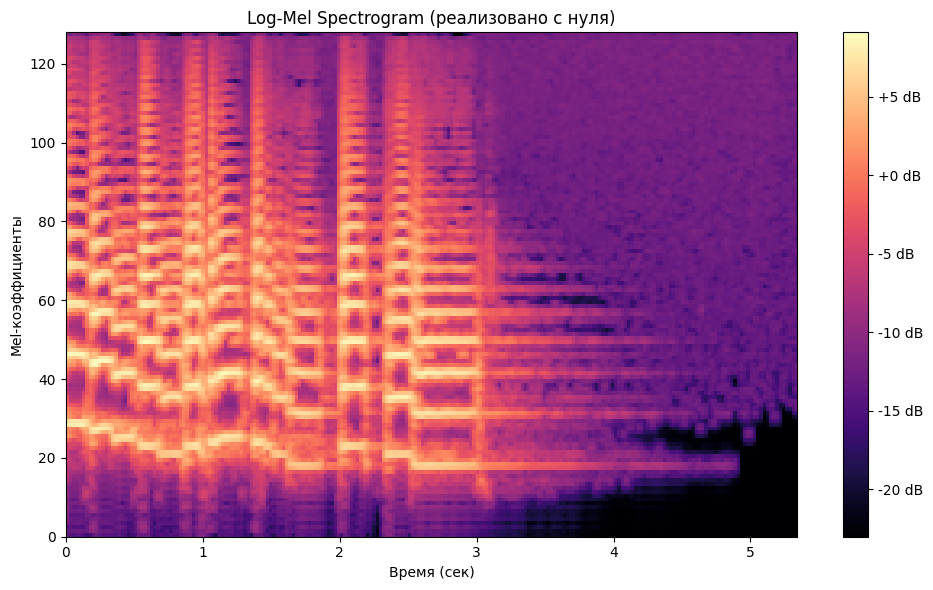

In [79]:
plt.figure(figsize=(10, 6))
plt.imshow(
    log_mel_spectrogram.T,
    aspect='auto',
    origin='lower',
    cmap='magma',
    extent=[0, len(wav)/sr, 0, n_mels]
)
plt.title('Log-Mel Spectrogram (реализовано с нуля)')
plt.xlabel('Время (сек)')
plt.ylabel('Mel-коэффициенты')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()